# **Predicting SLA Violations with Machine Learning**

---

This notebook predicts which service requests might breach their Service Level Agreement (SLA). It uses the cleaned data from the data cleaning notebook, runs baseline models to identify the best approach, and performs model tuning and training to evaluate performance.

## **Loading Data**

In [ ]:
import pandas as pd
import numpy as np

# Load cleaned data
data = pd.read_csv('/content/NYC 311 Cleaned Data.csv', low_memory = False)

## **Preparing Data**

In [ ]:
data.isna().sum()

,0
Unique Key,0
Created Date,0
Closed Date,0
Agency,0
Complaint Type,0
Descriptor,82570
Location Type,389918
Incident Zip,23542
Address Type,12179
Status,0


In [ ]:
# Remove rows with null values
data = data.dropna(subset = ['Latitude', 'Longitude', 'Location Type', 'SLA Hours', 'Address Type'])

In [ ]:
# Create 'SLA Breach' target variable
data['SLA Breach'] = (data['Resolution Time'] > data['SLA Hours']).astype(int)

# Distribution of target variable
print(data['SLA Breach'].value_counts(normalize = True))

SLA Breach
0    0.777295
1    0.222705
Name: proportion, dtype: float64


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2568496 entries, 0 to 3343291
Data columns (total 27 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Unique Key              int64  
 1   Created Date            object 
 2   Closed Date             object 
 3   Agency                  object 
 4   Complaint Type          object 
 5   Descriptor              object 
 6   Location Type           object 
 7   Incident Zip            float64
 8   Address Type            object 
 9   Status                  object 
 10  Borough                 object 
 11  Open Data Channel Type  object 
 12  Latitude                float64
 13  Longitude               float64
 14  Location Group          object 
 15  Resolution Time         float64
 16  Time of Day             object 
 17  Day of Week             object 
 18  Month                   object 
 19  Day & Time              object 
 20  Borough Agency          object 
 21  Borough Location        object 
 22 

## **Preprocessing**

In [ ]:
from sklearn.model_selection import train_test_split

data['Created Date'] = pd.to_datetime(data['Created Date'])
data = data[data['Created Date'] >= '2024-08-08']

# Filter input and target variables
data = data[['Borough', 'Agency', 'Borough Agency', 'Borough Location',
             'Location Type Grouped', 'Complaint Type Grouped',
             'Latitude', 'Longitude', 'Address Type', 'Open Data Channel Type',
             'Month', 'Day & Time', 'Time of Day', 'Day of Week',
             'Requests Past Week',  'SLA Breach']]

# Sample rows stratified by target
df_sample, _ = train_test_split(data,
                               train_size = 50000,
                               stratify = data['SLA Breach'],
                               random_state = 25)


# Train and test set split
train_df, test_df = train_test_split(
    df_sample,
    test_size = 0.2,
    stratify = df_sample['SLA Breach'],
    random_state=25
)

In [ ]:
# Split input and target variables
feature_cols = ['Borough', 'Agency', 'Borough Agency', 'Borough Location',
                'Location Type Grouped', 'Complaint Type Grouped', 'Latitude',
                'Longitude', 'Address Type', 'Open Data Channel Type', 'Month',
                'Day & Time', 'Time of Day', 'Day of Week', 'Requests Past Week']

x_train = train_df[feature_cols]
y_train = train_df['SLA Breach']

x_test = test_df[feature_cols]
y_test = test_df['SLA Breach']

# Numeric and categorical features
num_features = ['Requests Past Week', 'Latitude', 'Longitude']
cat_features = [col for col in feature_cols if col not in num_features]

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Preprocessing pipelines
preprocessor_lr_nn = ColumnTransformer(
    transformers = [
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown = 'ignore'), cat_features)
    ]
)

preprocessor_tree = ColumnTransformer(
    transformers = [
        ("num", "passthrough", num_features),
        ("cat", OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), cat_features)
    ]
)

## **Testing Baseline Models with 3-fold Cross Validation**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import cross_validate

In [ ]:
# Baseline models
models = {
    "Logistic Regression": (LogisticRegression(), preprocessor_lr_nn),
    "Neural Network": (MLPClassifier(random_state = 25), preprocessor_lr_nn),
    "Decision Tree": (DecisionTreeClassifier(random_state = 25), preprocessor_tree),
    "Random Forest": (RandomForestClassifier(random_state = 25), preprocessor_tree),
    "XGBoost": (XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state = 25, enable_categorical = True), preprocessor_tree)
}

results = {}

# Cross validation for baseline models
print("Running 3 fold CV with SMOTE NC for class imbalance")
for name, (model, preprocessor) in models.items():

    try:
        pipeline = Pipeline([
            ('smote', SMOTENC(categorical_features = [x_train.columns.get_loc(c) for c in cat_features], random_state = 25)),
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        cv = cross_validate(
            pipeline, x_train, y_train,
            cv = 3,
            scoring = ['accuracy', 'f1_macro'],
            return_train_score = True,
            n_jobs = -1
        )

        results[name] = {
            'mean_train_accuracy': np.mean(cv['train_accuracy']),
            'mean_val_accuracy': np.mean(cv['test_accuracy']),
            'mean_train_f1_macro': np.mean(cv['train_f1_macro']),
            'mean_val_f1_macro': np.mean(cv['test_f1_macro']),
        }

    except Exception as e:
        print(f"Error processing {name}: {e}")
        results[name] = {'error': str(e)}

# Results
for name, res in results.items():
    print(f"\n{name} results:")
    if 'error' in res:
        print(f"Error: {res['error']}")
    else:
        print(f"  Train Accuracy: {res['mean_train_accuracy']:.4f}")
        print(f"  Validation Accuracy: {res['mean_val_accuracy']:.4f}")
        print(f"  Train F1 Macro: {res['mean_train_f1_macro']:.4f}")
        print(f"  Validation F1 Macro: {res['mean_val_f1_macro']:.4f}")

Running 3 fold CV with SMOTE NC for class imbalance

Logistic Regression results:
  Train Accuracy: 0.7944
  Validation Accuracy: 0.7926
  Train F1 Macro: 0.7369
  Validation F1 Macro: 0.7346

Neural Network results:
  Train Accuracy: 0.9264
  Validation Accuracy: 0.8101
  Train F1 Macro: 0.8939
  Validation F1 Macro: 0.7295

Decision Tree results:
  Train Accuracy: 0.9999
  Validation Accuracy: 0.7857
  Train F1 Macro: 0.9998
  Validation F1 Macro: 0.7108

Random Forest results:
  Train Accuracy: 0.9999
  Validation Accuracy: 0.8424
  Train F1 Macro: 0.9998
  Validation F1 Macro: 0.7750

XGBoost results:
  Train Accuracy: 0.8828
  Validation Accuracy: 0.8407
  Train F1 Macro: 0.8316
  Validation F1 Macro: 0.7714


## **XGBoost Modeling**

### **Hyperparameter Tuning with Randomzied Search & Cross Validation**

In [ ]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

### Prepare data with preprocessed features
x_train_processed = preprocessor_tree.fit_transform(x_train)
x_test_processed = preprocessor_tree.transform(x_test)

# Find indices of categorical features in the preprocessed features for SMOTE NC
preprocessed_features = preprocessor_tree.get_feature_names_out()
cat_indices = [i for i, name in enumerate(preprocessed_features) if name.startswith('cat__')]

### Pipeline with SMOTENC and XGBClassifier
pipeline = Pipeline([
       ('smote', SMOTENC(categorical_features = cat_indices, random_state = 25)),
       ('classifier', XGBClassifier(
           eval_metric = 'logloss',
           n_jobs = -1,
           random_state = 25,
           enable_categorical = True,
       ))
])

### Define hyperparameter search space for Randomized Search
random_parameters = {
       "classifier__n_estimators": [100, 200, 300],
       "classifier__max_depth": [3, 5, 7],
       "classifier__learning_rate": [0.01, 0.05, 0.1],
       "classifier__subsample": [0.8, 1.0]
}

### RandomizedSearch with 5-fold stratified CV
random_search = RandomizedSearchCV(
       estimator = pipeline,
       param_distributions = random_parameters,
       n_iter = 30,
       scoring = {'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
       refit = 'f1_macro',
       cv = StratifiedKFold(5, shuffle = True, random_state = 25),
       n_jobs = -1,
       verbose = 2,
       return_train_score = True,
       random_state = 25
)

### Fit RandomizedSearchCV on preprocessed data and target
print("Running hyperparameter tuning with Randomized Search CV")
random_search.fit(x_train_processed, y_train)

print("\nBest parameters:")
print(random_search.best_params_)


Running hyperparameter tuning with Randomized Search CV
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters:
{'classifier__subsample': 0.8, 'classifier__n_estimators': 200, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.1}


### **Evaluating & Testing the Final Model**

In [ ]:
### Select the best estimator
best_pipeline = random_search.best_estimator_

print("\nFitting the best pipeline using the full training data")
best_pipeline.fit(x_train_processed, y_train)

print("Training complete.")


Fitting the best pipeline using the full training data
Training complete.


Evaluating the trained model on all features

Training set performance
Training Accuracy: 0.8777
Training F1 Score: 0.8251

Test set performance
Test Accuracy: 0.8492
Test F1 Macro: 0.7851


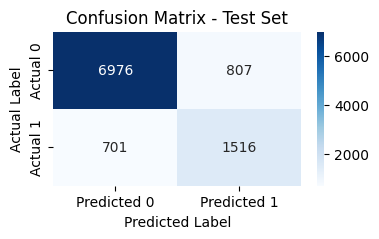

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Evaluate the best pipeline on the full training and test sets.
print("Evaluating the trained model on all features")

# ----- Training evaluation -----
print("\nTraining set performance")
y_pred_train_all = best_pipeline.predict(x_train_processed)
train_accuracy_all = accuracy_score(y_train, y_pred_train_all)
train_f1_macro_all = f1_score(y_train, y_pred_train_all, average = 'macro')
print(f"Training Accuracy: {train_accuracy_all:.4f}")
print(f"Training F1 Score: {train_f1_macro_all:.4f}")

# ----- Test evaluation -----
print("\nTest set performance")
y_pred_test_all = best_pipeline.predict(x_test_processed)
test_accuracy_all = accuracy_score(y_test, y_pred_test_all)
test_f1_macro_all = f1_score(y_test, y_pred_test_all, average = 'macro')
print(f"Test Accuracy: {test_accuracy_all:.4f}")
print(f"Test F1 Macro: {test_f1_macro_all:.4f}")

cm_test_all = confusion_matrix(y_test, y_pred_test_all)
plt.figure(figsize = (4, 2))
sns.heatmap(cm_test_all, annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = ['Predicted 0', 'Predicted 1'],
            yticklabels = ['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

### **Feature Selection Based on Permutation Importance**


Permutation Importance
                        Feature  Importance
5           cat__Borough Agency    0.241383
6         cat__Borough Location    0.220163
3                  cat__Borough    0.206362
12              cat__Day & Time    0.202939
14             cat__Day of Week    0.182748
4                   cat__Agency    0.168179
1                 num__Latitude    0.159606
2                num__Longitude    0.090845
8   cat__Complaint Type Grouped    0.088989
7    cat__Location Type Grouped    0.040857
0       num__Requests Past Week    0.038655
13             cat__Time of Day    0.027139
11                   cat__Month    0.017018
10  cat__Open Data Channel Type    0.001847
9             cat__Address Type    0.001282


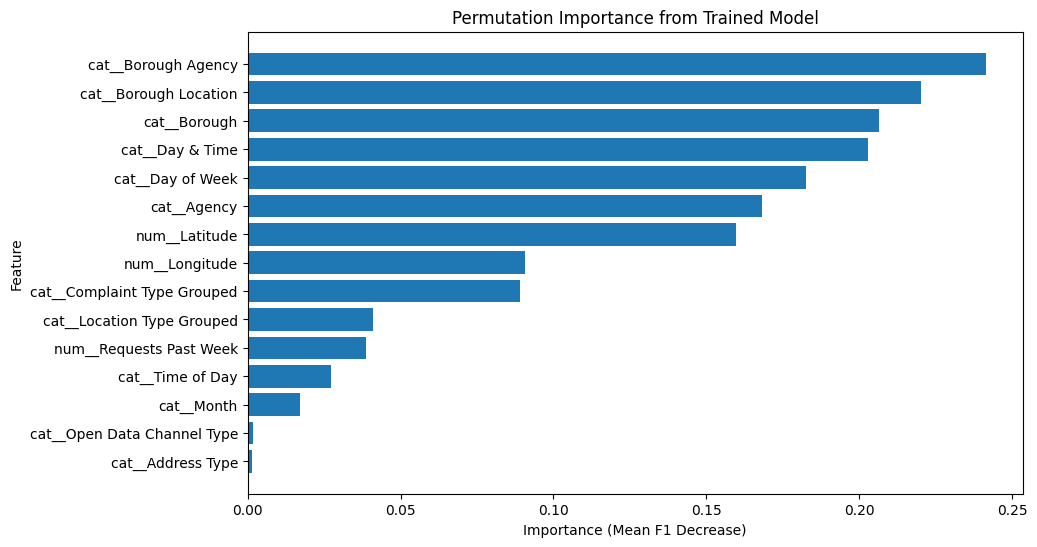

In [ ]:
from sklearn.inspection import permutation_importance

### Permutation importance
# Calculate on preprocessed test data
permutation_i = permutation_importance(
       best_pipeline.named_steps['classifier'], x_test_processed, y_test,
       scoring = 'f1_macro', n_repeats = 10, random_state = 25, n_jobs = -1
)

# Names of full preprocessed data
processed_features = preprocessor_tree.get_feature_names_out()

# Processed features and permutation importance in a dataframe
importances_df = pd.DataFrame({
       'Feature': processed_features,
       'Importance': permutation_i.importances_mean
}).sort_values(by = 'Importance', ascending = False)

print("\nPermutation Importance")
print(importances_df)

# Bar chart of permutation importance
plt.figure(figsize = (10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Importance (Mean F1 Decrease)")
plt.ylabel("Feature")
plt.title("Permutation Importance from Trained Model")
plt.show()

Selected features based on permutation importance threshold (0.02):
['num__Requests Past Week' 'num__Latitude' 'num__Longitude' 'cat__Borough'
 'cat__Agency' 'cat__Borough Agency' 'cat__Borough Location'
 'cat__Location Type Grouped' 'cat__Complaint Type Grouped'
 'cat__Day & Time' 'cat__Time of Day' 'cat__Day of Week']

Evaluating trained model on features selected by permutation importance

Training set performance
Training Accuracy: 0.8681
Training F1 Score: 0.8109

Test set performance
Test Accuracy: 0.8413
Test F1 Macro: 0.7746


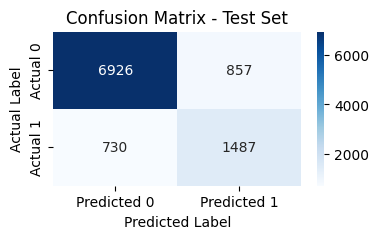

In [ ]:
### Feature selection by permutation importance threshold
threshold = 0.02

final_selected_features_mask = permutation_i.importances_mean >= threshold
final_selected_feature_names = processed_features[final_selected_features_mask]

print(f"Selected features based on permutation importance threshold ({threshold}):")
print(final_selected_feature_names)

# Slice training and test sets based on the selected features
x_train_final = x_train_processed[:, final_selected_features_mask]
x_test_final  = x_test_processed[:, final_selected_features_mask]

# Indices of categorical features from selected features
final_cat_indices = [i for i, name in enumerate(final_selected_feature_names) if name.startswith('cat__')]

# Extract best classifier parameters from best_pipeline
best_params = random_search.best_params_
best_classifier_params = {key.replace('classifier__', ''): value for key, value in best_params.items() if key.startswith('classifier__')}

# Train final model with best hyperparameters on selected features
final_model_pipeline = Pipeline([
    ('smote', SMOTENC(categorical_features = final_cat_indices, random_state = 25)),
    ('classifier', XGBClassifier(
        eval_metric = 'logloss',
        n_jobs = -1,
        random_state = 25,
        **best_classifier_params
    ))
])

### Training final model on selected features
final_model_pipeline.fit(x_train_final, y_train)

print("\nEvaluating trained model on features selected by permutation importance")

# ----- Training evaluation -----
print("\nTraining set performance")
y_pred_train = final_model_pipeline.predict(x_train_final)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1_macro = f1_score(y_train, y_pred_train, average = 'macro')
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training F1 Score: {train_f1_macro:.4f}")

# ----- Test evaluation -----
print("\nTest set performance")
y_pred_test = final_model_pipeline.predict(x_test_final)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1_macro = f1_score(y_test, y_pred_test, average = 'macro')
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Macro: {test_f1_macro:.4f}")

cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize = (4, 2))
sns.heatmap(cm_test, annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = ['Predicted 0', 'Predicted 1'],
            yticklabels = ['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

### **Threshold Tuning to Optimize F1 Score**

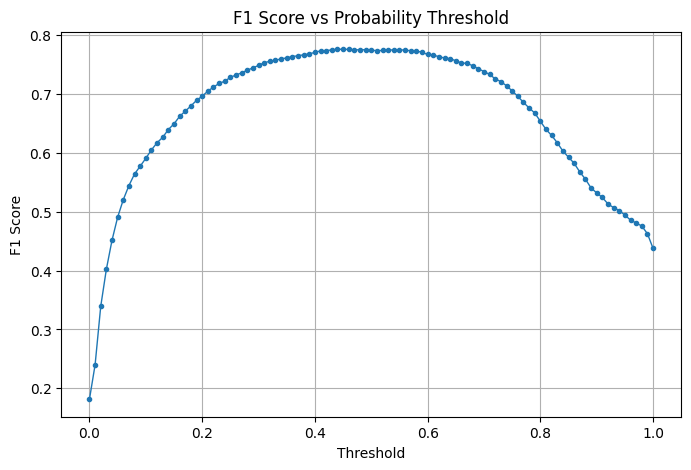

Best threshold: 0.440, F1: 0.7764


In [ ]:
### Threshold tuning
# Predicted probabilities for positive class
#y_probs_test = final_model_pipeline.predict_proba(x_test_final)[:, 1]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

thresholds = np.linspace(0, 1, 101)
mean_f1_scores = []

# Loop through thresholds
for t in thresholds:
    f1_cv_scores = []

    for train_idx, val_idx in cv.split(x_train_processed, y_train):
        x_tr, x_val = x_train_processed[train_idx], x_train_processed[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train on train split
        model = final_model_pipeline.fit(x_tr, y_tr)

        # Predict probabilities
        y_probs_val = model.predict_proba(x_val)[:, 1]
        y_pred_val = (y_probs_val >= t).astype(int)

        # Save F1 for this fold
        f1_cv_scores.append(f1_score(y_val, y_pred_val, average="macro"))

    # Store mean F1 for this threshold
    mean_f1_scores.append(np.mean(f1_cv_scores))

# Find best threshold
best_idx = np.argmax(mean_f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = mean_f1_scores[best_idx]

# Plot F1 vs Threshold
plt.figure(figsize = (8,5))
plt.plot(thresholds, mean_f1_scores, marker = 'o', linestyle = '-', linewidth = 1, markersize = 3)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Probability Threshold')
plt.grid(True)
plt.show()

# Best threshold
best_idx = np.argmax(mean_f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = mean_f1_scores[best_idx]

print(f"Best threshold: {best_threshold:.3f}, F1: {best_f1:.4f}")



Evaluating trained model using optimal probability threshold

Training set performance
Training Accuracy: 0.8614
Training F1 Score: 0.8096

Test set performance
Test Accuracy: 0.8360
Test F1 Macro: 0.7764


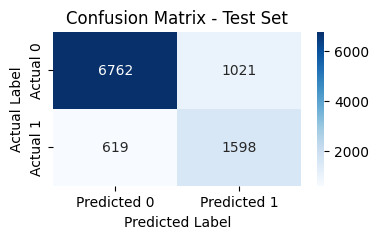

In [ ]:
### Best threshold to evaluate
print("\nEvaluating trained model using optimal probability threshold")

# ----- Training evaluation -----
print("\nTraining set performance")
y_pred_train = (final_model_pipeline.predict_proba(x_train_final)[:, 1] >= best_threshold).astype(int)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1_macro = f1_score(y_train, y_pred_train, average = 'macro')
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training F1 Score: {train_f1_macro:.4f}")

# ----- Test evaluation -----
print("\nTest set performance")
y_pred_test = (final_model_pipeline.predict_proba(x_test_final)[:, 1] >= best_threshold).astype(int)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1_macro = f1_score(y_test, y_pred_test, average = 'macro')
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Macro: {test_f1_macro:.4f}")

cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize = (4, 2))
sns.heatmap(cm_test, annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = ['Predicted 0', 'Predicted 1'],
            yticklabels = ['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()